In [1]:
import tensorflow as tf

print('tensorflow version = ', tf.__version__)

tensorflow version =  2.10.1


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
# Define relevant variables for the ML task
image_size = (480, 256)
input_shape = (480, 256, 3)
batch_size = 16
num_classes = 4
learning_rate = 0.0015
num_epochs = 100

In [4]:
import tensorflow as tf
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# 字典對應表
dict_for_label = {
    'boat': [1, 0, 0, 0], 'dolphin': [0, 1, 0, 0], 'fish': [0, 0, 1, 0], 'whale': [0, 0, 0, 1],
    'boat+fish': [1, 0, 1, 0], 'boat+whale': [1, 0, 0, 1],
    'dolphin+boat': [1, 1, 0, 0], 'dolphin+whale': [0, 1, 0, 1], 'dolphin+fish': [0, 1, 1, 0],
    'fish+whale': [0, 0, 1, 1]
}

# 自訂多標籤資料集
class MultiLabelImageDataset(tf.keras.utils.Sequence):
    def __init__(self, image_folder, label_mapping, target_size=(224, 224), batch_size=32):
        """
        初始化資料集
        :param image_folder: 圖片資料夾的路徑
        :param label_mapping: 標籤字典
        :param target_size: 圖片調整大小
        :param batch_size: 每批的大小
        """
        self.image_folder = image_folder
        self.label_mapping = label_mapping
        self.target_size = target_size
        self.batch_size = batch_size

        # 掃描資料夾內的所有圖片
        self.image_paths = []
        self.labels = []
        for class_name, one_hot in label_mapping.items():
            class_folder = os.path.join(image_folder, class_name) # find specific folder
            if os.path.exists(class_folder):
                for file_name in os.listdir(class_folder):
                    if file_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_folder, file_name))
                        self.labels.append(one_hot)

        # 將資料轉換為 numpy 陣列
        self.image_paths = np.array(self.image_paths)
        self.labels = np.array(self.labels, dtype=np.float32)

    def __len__(self):
        """定義每個 epoch 包含的批次數"""
        return len(self.image_paths) # self.batch_size

    def __getitem__(self, idx):
        """獲取一批資料"""
        # list slicing
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for image_path in batch_images:
            # 加載圖片並調整大小
            img = load_img(image_path, target_size=self.target_size)
            img_array = img_to_array(img) / 255.0  # 標準化到 [0, 1]
            images.append(img_array)

        return np.array(images), np.array(batch_labels)


In [5]:
# 使用自定義的多標籤資料集
train_folder = "dataset_v3/train"
test_folder = "dataset_v3/test"

def load_dataset(image_folder, label_mapping, target_size, batch_size):
    # 創建資料集實例
    dataset = MultiLabelImageDataset(
        image_folder=image_folder,
        label_mapping=dict_for_label,
        target_size=image_size,
        batch_size=batch_size
    )

    # 將資料集轉換為 TensorFlow Dataset 格式
    def generator():
        for i in range(len(dataset)):
            images, labels = dataset[i]  # 確保 dataset[i] 返回的是單張圖片和對應標籤
            for j in range(len(images)):
                yield images[j], labels[j]

    # TensorFlow Dataset API
    tf_dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            (image_size[0], image_size[1], 3),  # Image shape: (height, width, channels)
            (len(dict_for_label["boat"]),)       # Label shape: (num_classes,)
        )
    )

    # 打亂資料集並分批次
    tf_dataset = tf_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)
    return tf_dataset

train_dataset = load_dataset(train_folder, dict_for_label, image_size, batch_size)
test_dataset = load_dataset(test_folder, dict_for_label, image_size, batch_size)

# 測試加載資料
for images, labels in train_dataset.take(1):  # 取第一個批次
    print("Images shape:", images.shape)  # (batch_size, height, width, channels)
    print("Labels shape:", labels.shape)  # (batch_size, num_classes)
    print("First label:", labels[0].numpy())  # 查看第一張圖片的標籤
    break

Images shape: (16, 480, 256, 3)
Labels shape: (16, 4)
First label: [0. 0. 1. 0.]


Create model

In [6]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# class CNN_Model(models.Model):
#     def __init__(self):
#         super(CNN_Model, self).__init__()
#         self.layer1 = self.conv_module_for_5x5(3, 8, 3, 1) 
#         self.layer2 = self.conv_twice(8, 14, 3, 1) 
#         self.layer3 = self.conv_twice(14, 44, 3, 1) 
#         self.layer4 = self.conv_twice(44, 20, 3, 1) 
#         self.layer5 = self.conv_twice_for_5x5(20, 8, 3, 1) 
#         self.fc1 = layers.Dense(4)

#     def call(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = tf.reshape(out, (tf.shape(out)[0], -1))
#         out = self.fc1(out)
#         return out

#     def conv_module(self, in_channels, out_channels, kernel_size, stride, padding=0):
#         return models.Sequential([
#             layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same' if padding > 0 else 'valid', input_shape=(None, None, in_channels)),
#             layers.ReLU(),
#             layers.BatchNormalization(),
#             layers.MaxPool2D(pool_size=(2, 2))
#         ])

#     def conv_module_for_5x5(self, in_channels, out_channels, kernel_size, stride, padding=0):
#         return models.Sequential([
#             layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same' if padding > 0 else 'valid', input_shape=(None, None, in_channels)),
#             layers.ReLU(),
#             layers.ZeroPadding2D(padding=1),
#             layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same' if padding > 0 else 'valid'),
#             layers.ReLU(),
#             layers.BatchNormalization(),
#             layers.MaxPool2D(pool_size=(2, 2))
#         ])

#     def conv_twice(self, in_channels, out_channels, kernel_size, stride, padding=0):
#         return models.Sequential([
#             layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='same' if padding > 0 else 'valid', input_shape=(None, None, in_channels)),
#             layers.ReLU(),
#             layers.ZeroPadding2D(padding=1),
#             layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same' if padding > 0 else 'valid'),
#             layers.ReLU(),
#             layers.BatchNormalization(),
#             layers.MaxPool2D(pool_size=(2, 2))
#         ])

#     def conv_twice_for_5x5(self, in_channels, out_channels, kernel_size, stride, padding=0):
#         return models.Sequential([
#             layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='same' if padding > 0 else 'valid', input_shape=(None, None, in_channels)),
#             layers.ReLU(),
#             layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same' if padding > 0 else 'valid'),
#             layers.ReLU(),
#             layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same' if padding > 0 else 'valid'),
#             layers.ReLU(),
#             layers.BatchNormalization(),
#             layers.MaxPool2D(pool_size=(2, 2))
#         ])

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2

# 使用 Sequential 定義模型
model = models.Sequential()

# Layer 1
model.add(layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='valid', kernel_initializer=GlorotUniform(), activation='relu', input_shape=(480, 256, 3)))
model.add(layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='valid', kernel_initializer=GlorotUniform(), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(layers.Conv2D(14, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=GlorotUniform(), activation='relu'))
model.add(layers.Conv2D(14, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                         kernel_initializer=GlorotUniform(), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(layers.Conv2D(44, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=GlorotUniform(), activation='relu'))
model.add(layers.Conv2D(44, kernel_size=(3, 3), strides=(1, 1), padding='valid', 
                        kernel_initializer=GlorotUniform() , activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(layers.Conv2D(20, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=GlorotUniform(), activation='relu'))
model.add(layers.Conv2D(20, kernel_size=(3, 3), strides=(1, 1), padding='valid', 
                        kernel_initializer=GlorotUniform() , activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(layers.Conv2D(8, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=GlorotUniform(), activation='relu'))
model.add(layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='valid', 
                        kernel_initializer=GlorotUniform() , activation='relu'))
model.add(layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='valid', 
                        kernel_initializer=GlorotUniform(), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))

# Fully Connected Layer
model.add(layers.Dense(4, kernel_initializer=GlorotUniform()))

# 檢查模型結構
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 254, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 476, 252, 8)       584       
                                                                 
 batch_normalization (BatchN  (None, 476, 252, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 238, 126, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 238, 126, 14)      126       
                                                                 
 conv2d_3 (Conv2D)           (None, 236, 124, 14)      1

In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 優化器與損失函數
optimizer = Adam(learning_rate=learning_rate)
lossFunc = BinaryCrossentropy(from_logits=True)

# 編譯模型
model.compile(optimizer=optimizer, 
              loss=lossFunc, 
              metrics=['binary_accuracy'])

# 儲存模型的檔名
modelSaveName = "TFModel_v3.h5"

# 設置檢查點回調，儲存最佳模型權重
checkpoint = ModelCheckpoint(filepath=modelSaveName, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             mode='min', 
                             verbose=1)

# 開始訓練
history = model.fit(train_dataset,  # 訓練資料集
                    epochs=num_epochs,
                    validation_data=test_dataset,  # 驗證資料集 
                    callbacks=[checkpoint])  # 添加檢查點回調


Epoch 1/100
     11/Unknown - 25s 1s/step - loss: 0.5916 - binary_accuracy: 0.7315
Epoch 1: val_loss improved from inf to 0.69404, saving model to TFModel_v3.h5
11/11 [==============================] - 32s 2s/step - loss: 0.5916 - binary_accuracy: 0.7315 - val_loss: 0.6940 - val_binary_accuracy: 0.6568
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.3624 - binary_accuracy: 0.8318
Epoch 2: val_loss did not improve from 0.69404
11/11 [==============================] - 21s 2s/step - loss: 0.3624 - binary_accuracy: 0.8318 - val_loss: 0.7070 - val_binary_accuracy: 0.6568
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.2822 - binary_accuracy: 0.8781
Epoch 3: val_loss did not improve from 0.69404
11/11 [==============================] - 21s 2s/step - loss: 0.2822 - binary_accuracy: 0.8781 - val_loss: 0.7239 - val_binary_accuracy: 0.6568
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.2265 - binary_accuracy: 0.9043
Epoch 4: v

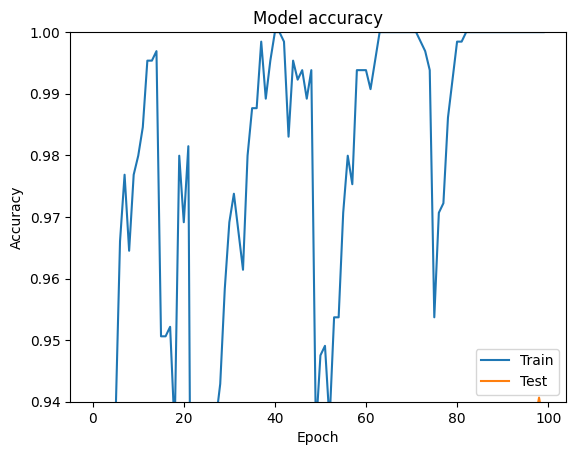

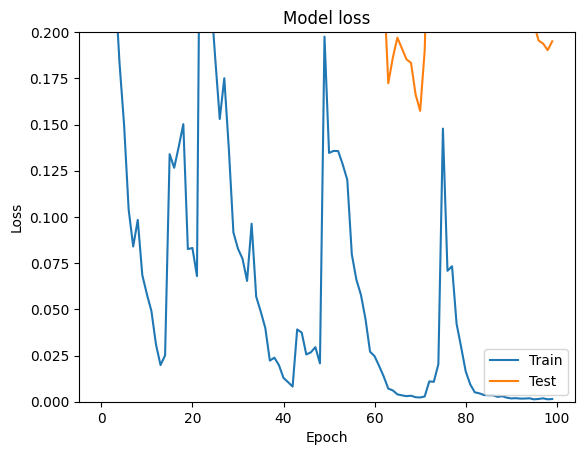

4/4 [==============================] - 3s 426ms/step - loss: 0.1951 - binary_accuracy: 0.9364
Test accuracy =  0.9364407062530518


In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.94, 1])
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 0.2])
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print('Test accuracy = ', test_acc)

Save json file

In [12]:
# 儲存模型架構
model_json = model.to_json()
with open("tf_model_structure.json", "w") as json_file:
    json_file.write(model_json)

預測資料

load h5 to model

In [13]:
model.load_weights('TFModel_v3.h5', by_name=True)
test_input = tf.random.normal([1, 480, 256, 3])
output = model(test_input)
print("Model output:", output)

Model output: tf.Tensor([[  4.5789123  -1.1022899 -18.926413   -7.3656244]], shape=(1, 4), dtype=float32)


Predict data like pytorch way

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf

# 初始化預測數據
pred_list = []
label_list = []

# 預測模型
for images, labels in test_dataset:
    # 預測輸出 (模型的 output 是 (batch_size, num_classes))
    outputs = model(images, training=False)
    # print(outputs)
    
    # 計算每個類別的預測概率（Sigmoid 函數處理）
    predicted_prob = tf.sigmoid(outputs)
    # print(predicted_prob)
    
    # 將每個類別的預測概率與閾值 0.5 比較，大於 0.5 表示該類別存在 (標記為 1)
    predicted = tf.cast(outputs > 0.5, tf.int32)
    # print(predicted)

    # 將預測和真實標籤加入列表
    pred_list.extend(predicted.numpy())
    label_list.extend(labels.numpy())

In [15]:
# 改為 numpy 陣列，便於計算
pred_list = np.array(pred_list)
label_list = np.array(label_list)

# 計算整體準確度
accuracy = accuracy_score(label_list, pred_list)
print(f'Subset Accuracy of the network on the test images: {accuracy * 100:.2f} %')

# 自定義的準確度函數
def Accuracy(y_pred, y_true):
    count = 0
    for i in range(y_true.shape[0]):  # 幾個樣本
        p = np.sum(np.logical_and(y_pred[i], y_true[i]))
        q = np.sum(np.logical_or(y_pred[i], y_true[i]))
        count += p / q
    return count / y_true.shape[0]

print(f'Accuracy of the network on the test images: {Accuracy(pred_list, label_list) * 100:.2f} %')

Subset Accuracy of the network on the test images: 79.66 %
Accuracy of the network on the test images: 85.31 %


In [16]:
# precision, recall, f1-score
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Precision: {precision_score(label_list, pred_list, average="samples")}')
print(f'Recall: {recall_score(label_list, pred_list, average="samples")}')
print(f'F1-score: {f1_score(label_list, pred_list, average="samples")}')

Precision: 0.8983050847457628
Recall: 0.864406779661017
F1-score: 0.8728813559322034


d:\ancode\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


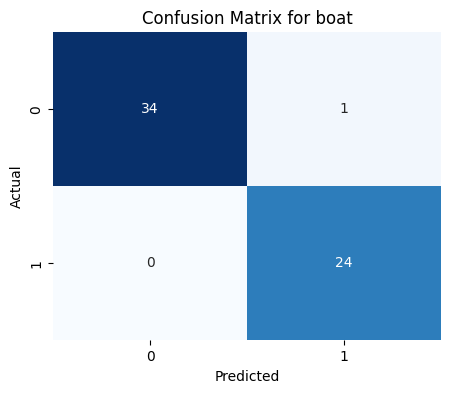

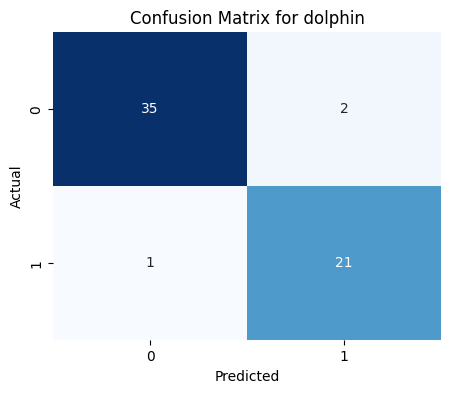

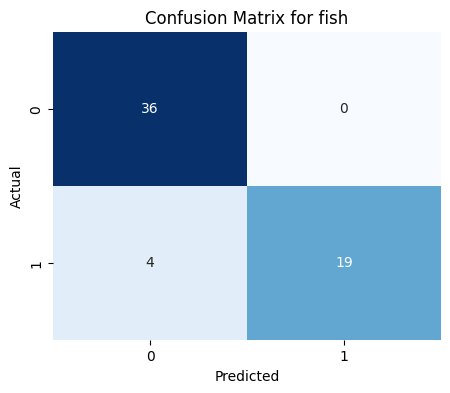

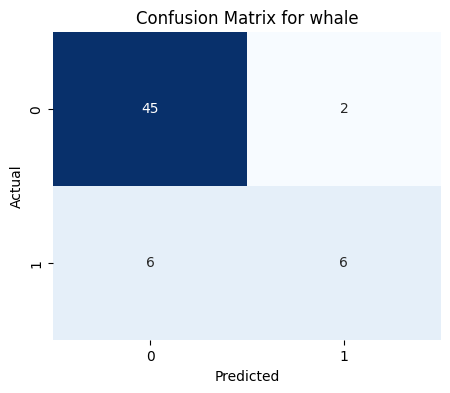

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

pred_list = np.array(pred_list)
label_list = np.array(label_list)

for i , class_name in enumerate(dict_for_label.keys()):
    if i >= num_classes:
        break

    cm = confusion_matrix(label_list[:, i], pred_list[:, i])
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [18]:
from sklearn.metrics import hamming_loss

# 計算 Hamming Loss
hloss = hamming_loss(label_list, pred_list)
print(f"Hamming Loss: {hloss}")

Hamming Loss: 0.06779661016949153
